In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from plot_utils import plot_training_time_and_speedup, table_for,plot_train_reward, plot_policy_consistency

## 1. Load results

### 1.1 Homogenous

In [2]:
homogenous_scm_results_path = "../marl_results/20250928_101823_scm_homogenous/marl_experiment_results_intermediate.json"
homogenous_net_results_path = "../marl_results/20250929_083123_net_homogenous/marl_experiment_results_intermediate.json"


with open(homogenous_scm_results_path, "r") as f:
    scm_results = json.load(f)

homogenous_scm_training_time = pd.DataFrame.from_dict(scm_results["training_time_stats"], orient="index", columns=["value"])
homogenous_scm_greedy_reward = pd.DataFrame.from_dict(scm_results["greedy_reward"], orient="index")
homogenous_scm_train_reward = pd.DataFrame.from_dict(scm_results["train_reward"], orient="index")

homogenous_scm_greedy_policy = scm_results["greedy_policy"]

homogenous_scm_emission_delta  = table_for(homogenous_scm_greedy_policy, "emission_delta")
homogenous_scm_prevention_rate = table_for(homogenous_scm_greedy_policy, "prevention_rate")


with open(homogenous_net_results_path, "r") as f:
    net_results = json.load(f)

homogenous_net_training_time = pd.DataFrame.from_dict(net_results["training_time_stats"], orient="index", columns=["value"])
homogenous_net_greedy_reward = pd.DataFrame.from_dict(net_results["greedy_reward"], orient="index")
homogenous_net_train_reward = pd.DataFrame.from_dict(net_results["train_reward"], orient="index")

homogenous_net_greedy_policy = net_results["greedy_policy"]

homogenous_net_emission_delta  = table_for(homogenous_net_greedy_policy, "emission_delta")
homogenous_net_prevention_rate = table_for(homogenous_net_greedy_policy, "prevention_rate")


### 1.2 Heterogenous

In [3]:
heterogenous_scm_results_path = "../marl_results/20250929_181306_scm_heterogeneous/marl_experiment_results_intermediate.json"
heterogenous_net_results_path = "../marl_results/20250929_150016_net_heterogeneous/marl_experiment_results_intermediate.json"

with open(heterogenous_scm_results_path, "r") as f:
    scm_results = json.load(f)

with open(heterogenous_net_results_path, "r") as f:
    net_results = json.load(f)

### SCM
heterogenous_scm_training_time = pd.DataFrame.from_dict(scm_results["training_time_stats"], orient="index", columns=["value"])
heterogenous_scm_greedy_reward = pd.DataFrame.from_dict(scm_results["greedy_reward"], orient="index")
heterogenous_scm_train_reward = pd.DataFrame.from_dict(scm_results["train_reward"], orient="index")
heterogenous_scm_greedy_policy = scm_results["greedy_policy"]
heterogenous_scm_emission_delta  = table_for(heterogenous_scm_greedy_policy, "emission_delta")
heterogenous_scm_prevention_rate = table_for(heterogenous_scm_greedy_policy, "prevention_rate")

### NET
heterogenous_net_training_time = pd.DataFrame.from_dict(net_results["training_time_stats"], orient="index", columns=["value"])
heterogenous_net_greedy_reward = pd.DataFrame.from_dict(net_results["greedy_reward"], orient="index")
heterogenous_net_train_reward = pd.DataFrame.from_dict(net_results["train_reward"], orient="index")
heterogenous_net_greedy_policy = net_results["greedy_policy"]
heterogenous_net_emission_delta  = table_for(heterogenous_net_greedy_policy, "emission_delta")
heterogenous_net_prevention_rate = table_for(heterogenous_net_greedy_policy, "prevention_rate")

## 2. Charts and figures

### 2.1 Training time

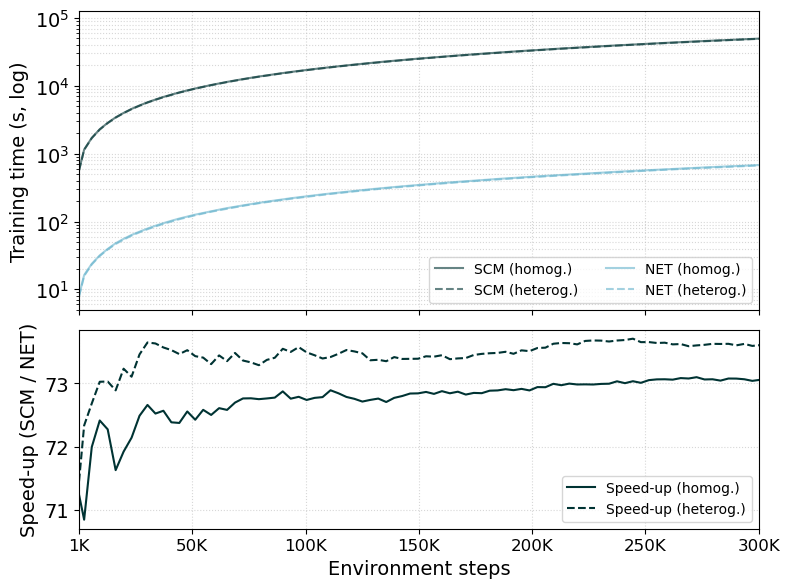

In [4]:
fig, axes = plot_training_time_and_speedup(
    homogenous_scm_training_time,
    homogenous_net_training_time,
    heterogenous_scm_training_time,
    heterogenous_net_training_time,
    cmap="ocean",
    savefig="plots/training_time_comparison_both_on_same_axes.pdf",
    xmax=300_000,
)

### 2.2 Reward over training steps

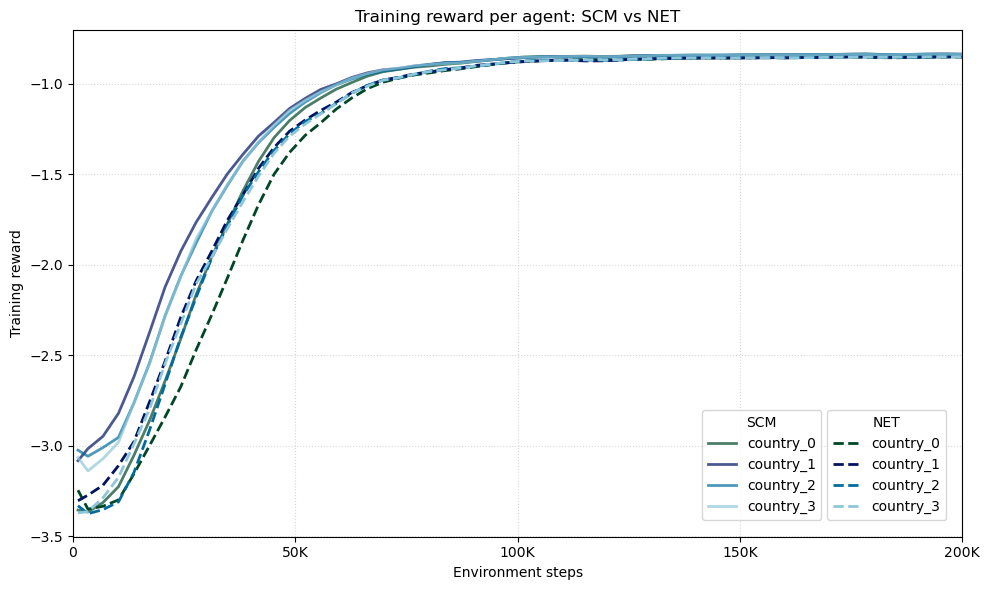

In [5]:
plot_train_reward(homogenous_scm_train_reward, homogenous_net_train_reward, steps_max=200_000,cmap="ocean")

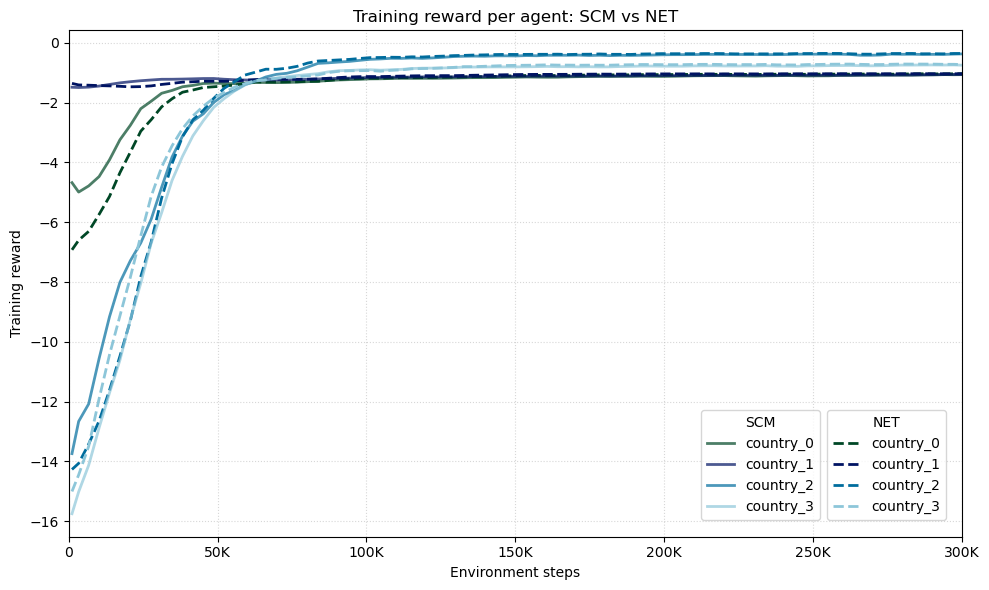

In [6]:
plot_train_reward(heterogenous_scm_train_reward, heterogenous_net_train_reward, steps_max=300_000,cmap="ocean")

### 2.3 Policy consistency

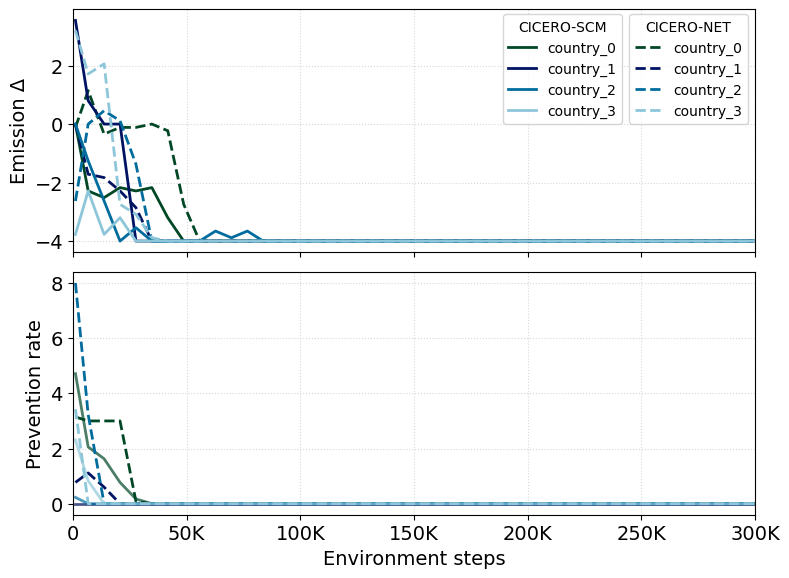

In [7]:
# Usage:
plot_policy_consistency(homogenous_scm_emission_delta, homogenous_net_emission_delta,
                        homogenous_scm_prevention_rate, homogenous_net_prevention_rate,
                        steps_max=300_000, cmap="ocean", savefig = "plots/homogenous_policy_consistency.pdf")

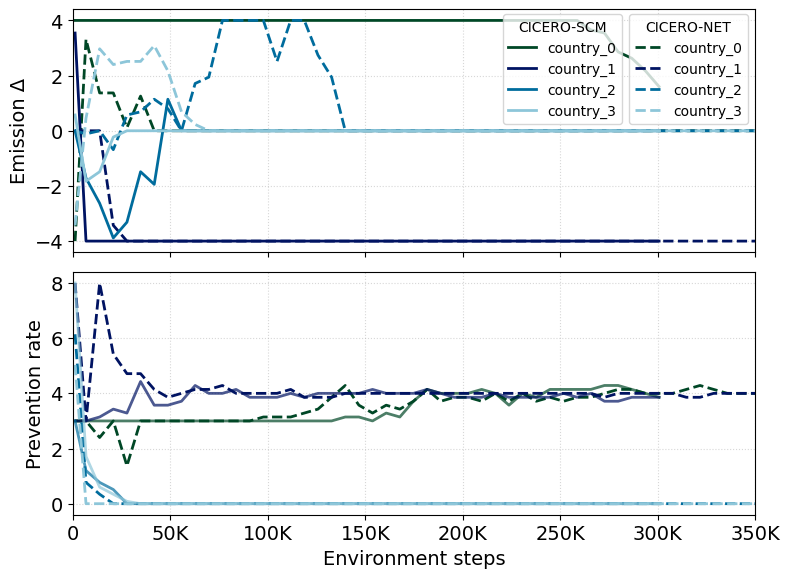

In [8]:
# Usage:
plot_policy_consistency(heterogenous_scm_emission_delta, heterogenous_net_emission_delta,
                        heterogenous_scm_prevention_rate, heterogenous_net_prevention_rate,
                        steps_max=350_000, cmap="ocean", savefig = "plots/heterogenous_policy_consistency.pdf")